In [1]:
import numpy as np

# Importing standard Qiskit libraries
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit.visualization import plot_histogram
from qiskit.algorithms.optimizers import COBYLA

from qiskit import *
import qiskit.quantum_info as qi
from qiskit.tools.visualization import plot_histogram
from qiskit.providers.aer import AerSimulator
from qiskit.providers.aer.noise import *
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
pi = math.pi

## Depolarizing noise

Here we are only considering the ideal case where the noise is only present for the delay operation.

In [2]:
noise_model = NoiseModel()

p_err = 0.02
error_1q = depolarizing_error(p_err,1) # 1 qubit depolarizing error
noise_model.add_all_qubit_quantum_error(error_1q, ['delay']) 

backend = AerSimulator(noise_model=noise_model)

Preparing the circuit with $|Ψ_{in}⟩ = U_{prep}|0⟩^{⊗n}$ here $θ = \frac{\pi}{2}$

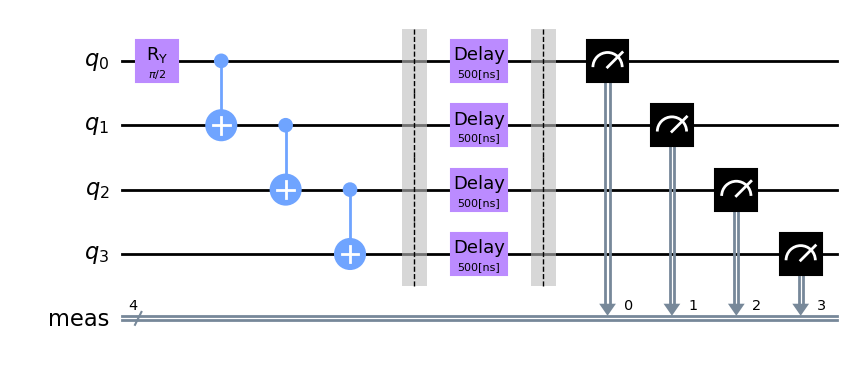

In [3]:
def U_prep(n_qubits,theta):
  qc = QuantumCircuit(n_qubits)
  qc.ry(theta,0)
  for qubit in range(n_qubits-1):
    qc.cx(qubit,qubit+1)
  qc.barrier()
  return qc

qc_without_hadamard = U_prep(4,pi/2)
qc_without_hadamard.delay(500,unit='ns')
qc_without_hadamard.measure_all()
qc_without_hadamard.draw('mpl')

### Backend without noise

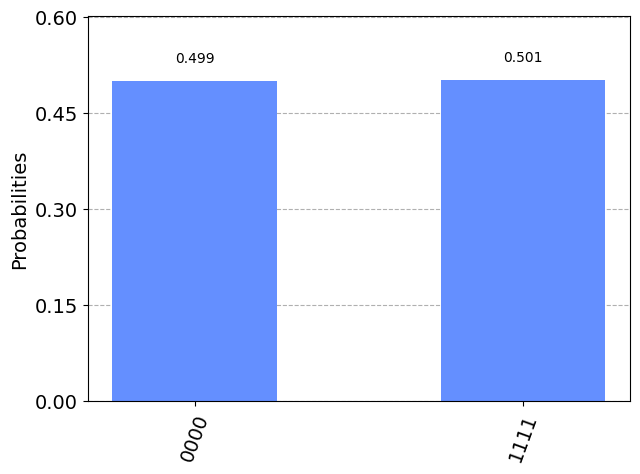

In [4]:
results_ideal = AerSimulator().run(qc_without_hadamard,shots=10000).result()
counts_ideal = results_ideal.get_counts()
plot_histogram(counts_ideal)

### This is our ground truth. Everything we do from here on is to reduce the effect of noise and make $|Ψ_{out}⟩$ as close to this measurement as possible

### Backend with noise

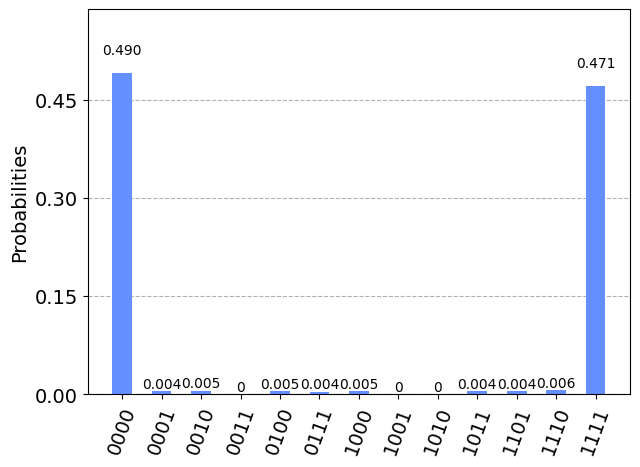

In [5]:
counts_without_hadamard = backend.run(qc_without_hadamard,shots=10000).result().get_counts()
plot_histogram(counts_without_hadamard)

### Our goal is to apply unitary $U$ and $V$ such that the effect noise is reduced by such operation.

Here we only apply $H$ gate

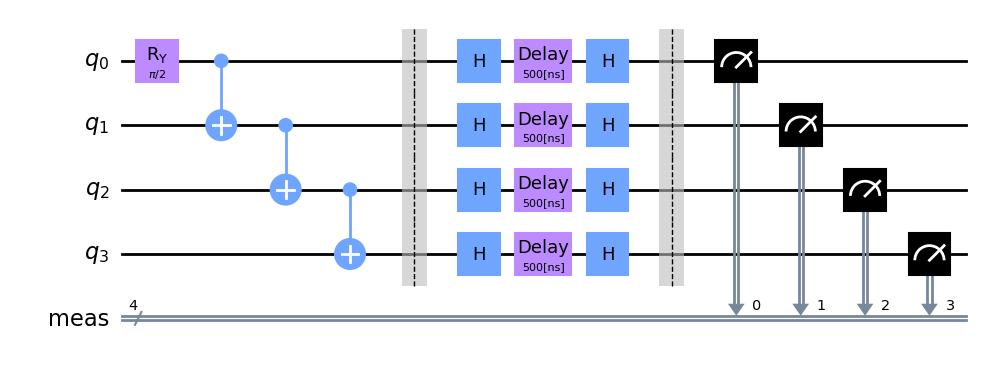

In [6]:
def padded_circuit(n_qubits,theta,delay):
  qc = U_prep(n_qubits,theta)

  for qubit in range(n_qubits):
    qc.h(qubit)
  qc.delay(delay,unit='ns')
  for qubit in range(n_qubits):
    qc.h(qubit)
  qc.measure_all()
  return qc

qc_with_hadamard = padded_circuit(4,pi/2, 500)
qc_with_hadamard.draw('mpl')


## Now measurement with noise

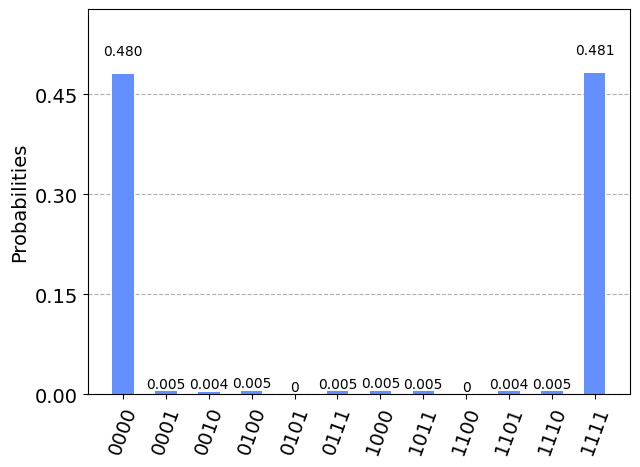

In [7]:
counts_with_hadamard = backend.run(qc_with_hadamard,shots=10000).result().get_counts()
plot_histogram(counts_with_hadamard)

### To measure the amount of noise in all the ways we could pad the circuit, we are defining some simple cost measurement functions:

From analysis of our circuit without any noise, we see the only valid states are 
$|0000⟩\ and \ |1111⟩$

In [8]:
# If state is not in the set of valid states, ouput is erroneous
def cost(counts):
  invalid_states_count = 0
  diff = 0
  counts = dict(counts)
  for state in counts.keys():
    if (state != '0000') and (state != '1111'):
      invalid_states_count += counts[state]
    # probability of getting the other 8 valid states is 5000/10000
    else:
        if (counts[state]-5000 >= 0):
            diff += (counts[state]-5000) # we got a valid state but how far is it from the ideal value? i.e deviation from correct value
  total_error = round((invalid_states_count + diff)/10000 , 4 )
  return {'invalid_states_count':invalid_states_count, 'deviation' : diff, 'error':total_error }


In [9]:
# counts = backend.run(qc,shots=10000).result().get_counts()
print(f"Error without noise: {cost(counts_ideal)}")
print(f"Error with noise without hadamard: {cost(counts_without_hadamard)}")
print(f"Error with noise with hadamard: {cost(counts_with_hadamard)}")

Error without noise: {'invalid_states_count': 0, 'deviation': 7, 'error': 0.0007}
Error with noise without hadamard: {'invalid_states_count': 390, 'deviation': 0, 'error': 0.039}
Error with noise with hadamard: {'invalid_states_count': 390, 'deviation': 0, 'error': 0.039}


We can see that by padding

$U=H$ and $V=H$

has resulted in the reduction of noise

### Now we iterate over all different possible types of gates and calculate their respective errors

In [10]:
# Complete this function
def pad_circuits_with_gates(n_qubits,theta,delay):  
  qc = U_prep(n_qubits,theta)
  range_low, increment = 0, pi/32
  range_high = 2*pi - increment
  circuits = []
 
  
  angle1 = range_low
  while(angle1 <= range_high): # u = rx, v = rx
    angle2 = range_low
    while(angle2 <= range_high):

      qc_pad = qc.copy()

      for qubit in range(n_qubits):     # u = rx
        qc_pad.rx(angle1,qubit)

      qc_pad.delay(delay,unit='ns')

      for qubit in range(n_qubits):     # v = rx
        qc_pad.rx(angle2,qubit)
      
      qc_pad.measure_all()
      circuits.append((qc_pad, angle1,angle2))
      # a1.append(angle1)
      # a2.append(angle2)
      angle2 += increment
    angle1 += increment

  angle1 = range_low
  while(angle1 <= range_high): # u = rx, v = ry
    angle2 = range_low
    while(angle2 <= range_high):

      qc_pad = qc.copy()

      for qubit in range(n_qubits):     # u = rx
        qc_pad.rx(angle1,qubit)

      qc_pad.delay(delay,unit='ns')

      for qubit in range(n_qubits):     # v = ry
        qc_pad.ry(angle2,qubit)
      
      qc_pad.measure_all()
      circuits.append((qc_pad, angle1,angle2))
      # a1.append(angle1)
      # a2.append(angle2)
      angle2 += increment
    angle1 += increment

  angle1 = range_low
  while(angle1 <= range_high): # u = ry, v = rx
    angle2 = range_low
    while(angle2 <= range_high):

      qc_pad = qc.copy()

      for qubit in range(n_qubits):     # u = ry
        qc_pad.ry(angle1,qubit)

      qc_pad.delay(delay,unit='ns')

      for qubit in range(n_qubits):     # v = rx
        qc_pad.rx(angle2,qubit)
      
      qc_pad.measure_all()
      circuits.append((qc_pad, angle1,angle2))
      # a1.append(angle1)
      # a2.append(angle2)
      angle2 += increment
    angle1 += increment

  angle1 = range_low
  while(angle1 <= range_high): # u = ry, v = ry
    angle2 = range_low
    while(angle2 <= range_high):

      qc_pad = qc.copy()

      for qubit in range(n_qubits):     # u = ry
        qc_pad.ry(angle1,qubit)

      qc_pad.delay(delay,unit='ns')

      for qubit in range(n_qubits):     # v = ry
        qc_pad.ry(angle2,qubit)
      
      qc_pad.measure_all()
      circuits.append((qc_pad, angle1,angle2))
      # a1.append(angle1)
      # a2.append(angle2)
      angle2 += increment
    angle1 += increment

  return circuits

ckts = pad_circuits_with_gates(4,pi/2,500)

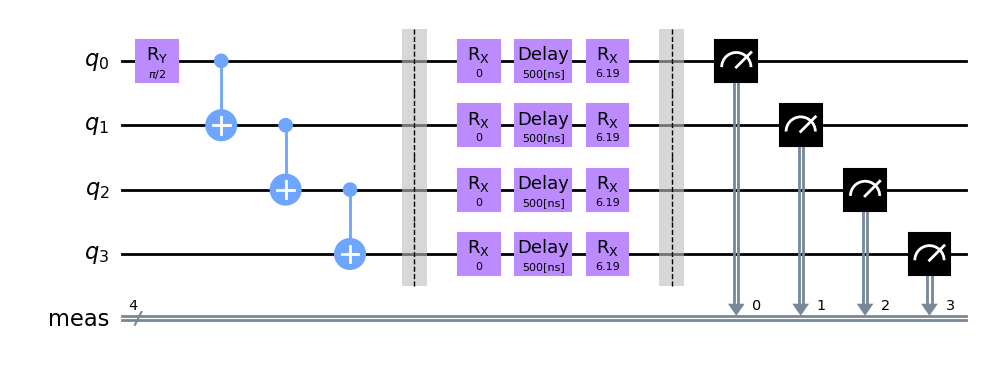

In [11]:
ckts[63][0].draw('mpl')

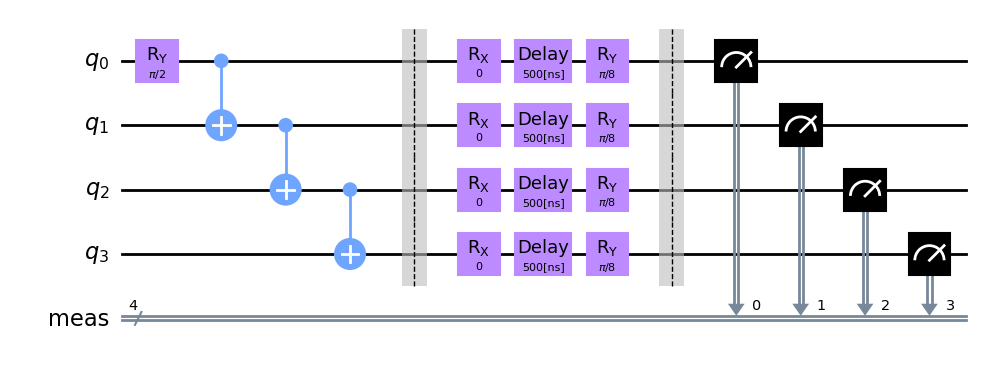

In [12]:
ckts[4100][0].draw('mpl')

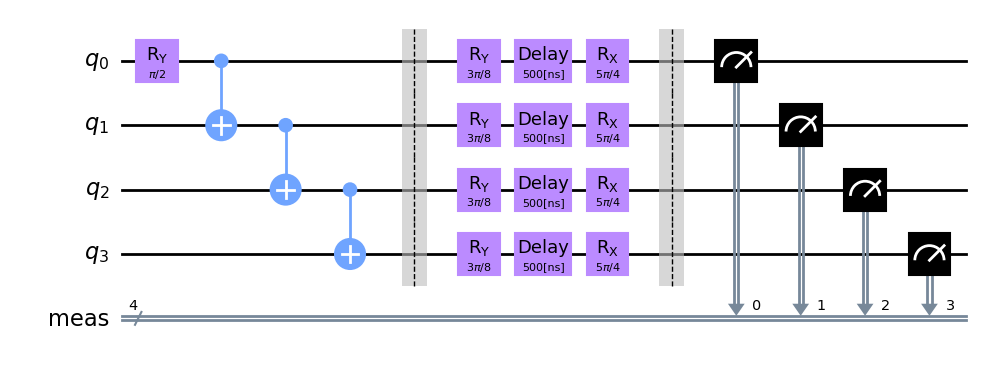

In [13]:
ckts[9000][0].draw('mpl')

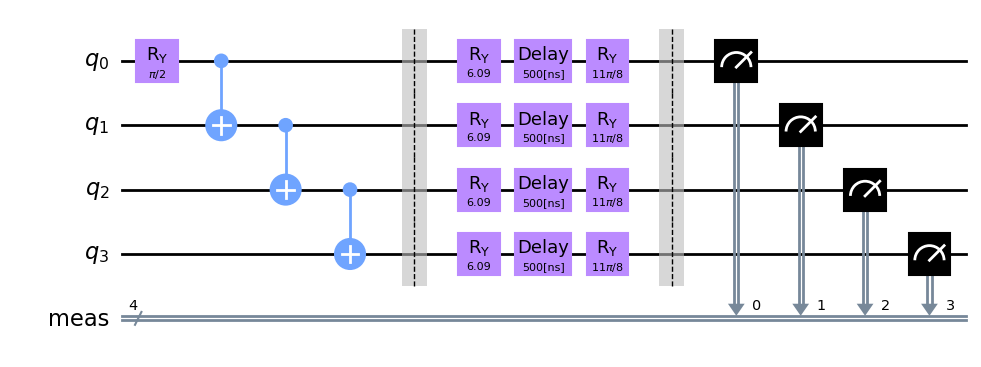

In [14]:
ckts[16300][0].draw('mpl')

### Measuring error for all the circuits and finding the circuit with least error

In [15]:
def getError(ckt_info):
  return ckt_info['error']

In [16]:
from tqdm import tqdm
min_error = 999999
min_err_info = None
min_ckt = None
theta = []
error = []

for ckt in tqdm(range(len(ckts))):
  qc = ckts[ckt][0]
  counts = backend.run(qc,shots=10000).result().get_counts()
  err = cost(counts)
  err['index'] = ckt
  error.append(err)

error.sort(key=getError)


100%|██████████| 16384/16384 [04:28<00:00, 61.05it/s]


In [17]:
print(error[0])

{'invalid_states_count': 330, 'deviation': 0, 'error': 0.033, 'index': 1670}


This is the optimal circuit we found

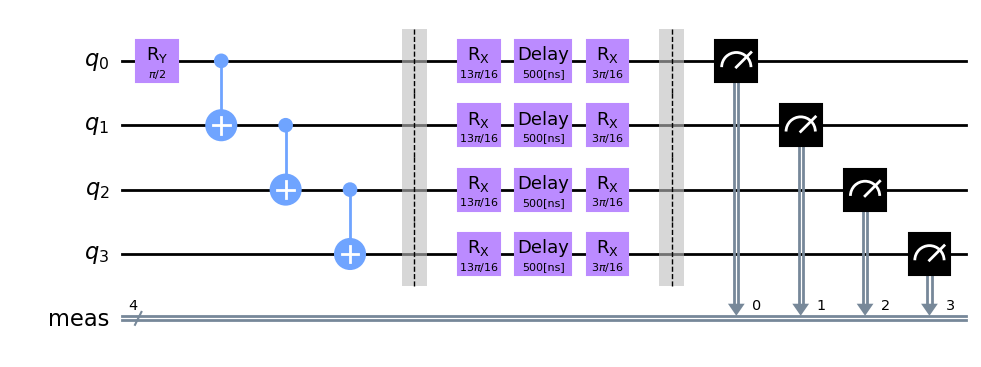

In [18]:
opt_idx = error[0]['index']
min_err_ckt = ckts[opt_idx][0]
min_err_ckt.draw('mpl')

In [19]:
errors = []
for i in range(len(ckts)):
  errors.append(error[i]['error'])

In [26]:
# %pip install ipympl #uncomment this line to install the plotting library

We now plot some interesting results

In [24]:
# for creating a responsive plot
%matplotlib widget

# Seprrating angles of U and V
x = np.array([ckt[:][1] for ckt in ckts ]) # U angle
x = np.array_split(x, len(x) / 4096)

y = np.array([ckt[:][2] for ckt in ckts ]) # V angle
y = np.array_split(y, len(y) / 4096)

z = np.array_split(np.array(errors), len(error)/4096 )


Error without applying any gate {'invalid_states_count': 390, 'deviation': 0, 'error': 0.039}
Error after applying hadamard gate {'invalid_states_count': 390, 'deviation': 0, 'error': 0.039}
Minimum error we found {'invalid_states_count': 330, 'deviation': 0, 'error': 0.033, 'index': 1670}


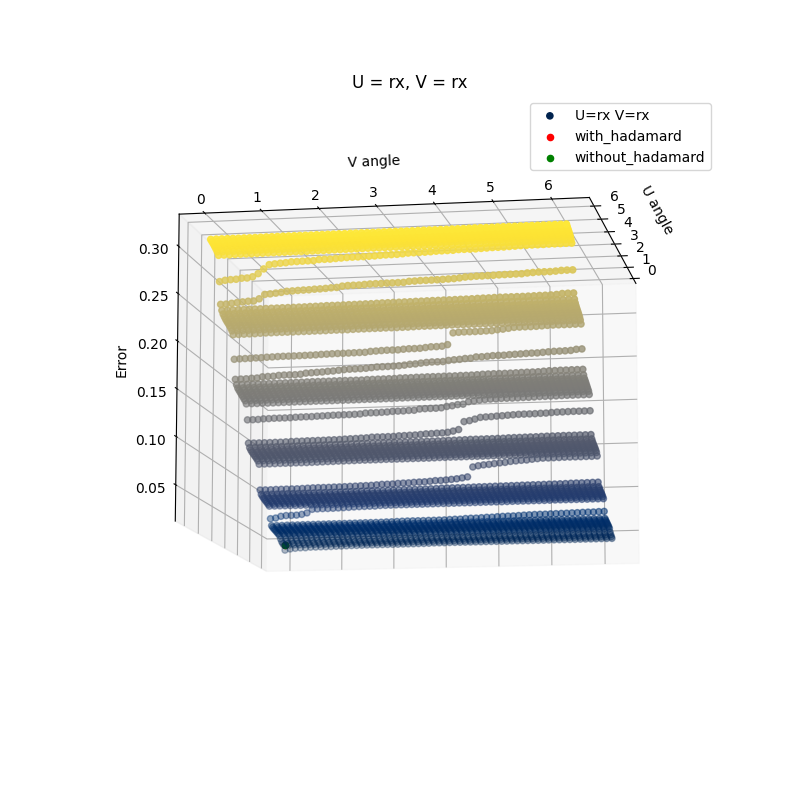

In [25]:
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection='3d')
ax.grid()
ax.set_title('U = rx, V = rx')
ax.set_xlabel('U angle')
ax.set_ylabel('V angle')
ax.set_zlabel('Error')

l1 = ax.scatter(x[0], y[0], z[0], c=z[0], cmap='cividis', label='U=rx V=rx')
l2 = ax.scatter(0,0,cost(counts_with_hadamard)['error'], color='red', label='with_hadamard')
l3 = ax.scatter(0,0,cost(counts_without_hadamard)['error'], color='green', label='without_hadamard')
ax.legend(handles=[l1, l2, l3])
ax.view_init(elev=-10, azim=10)

print(f"Error without applying any gate {cost(counts_without_hadamard)}")
print(f"Error after applying hadamard gate {cost(counts_with_hadamard)}")
print(f"Minimum error we found {error[0]}")
plt.show()

Error without applying any gate {'invalid_states_count': 390, 'deviation': 0, 'error': 0.039}
Error after applying hadamard gate {'invalid_states_count': 390, 'deviation': 0, 'error': 0.039}
Minimum error we found {'invalid_states_count': 330, 'deviation': 0, 'error': 0.033, 'index': 1670}


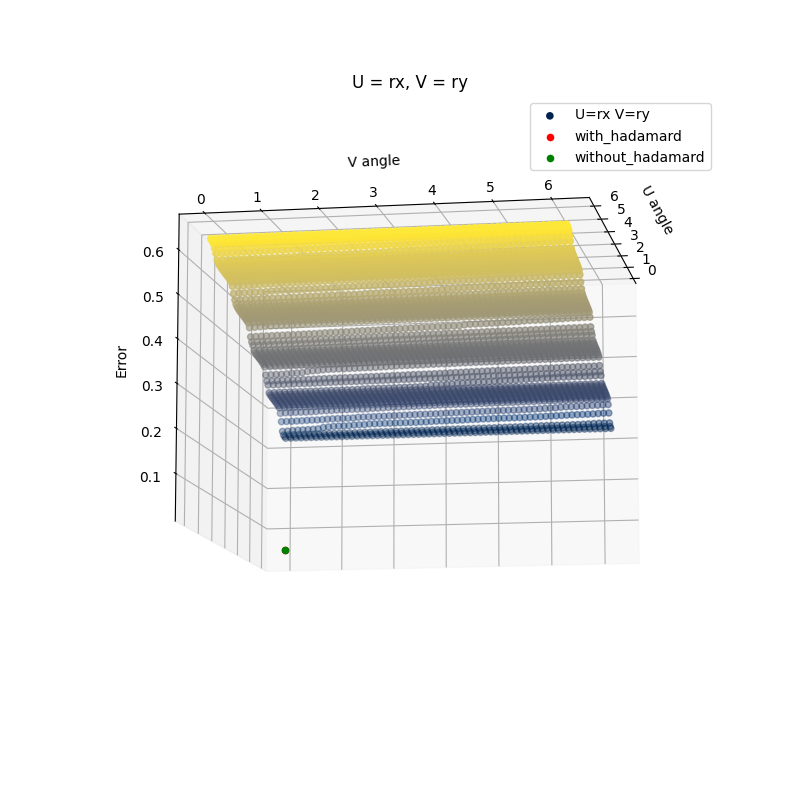

In [27]:
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection='3d')
ax.grid()
ax.set_title('U = rx, V = ry')
ax.set_xlabel('U angle')
ax.set_ylabel('V angle')
ax.set_zlabel('Error')

l1 = ax.scatter(x[1], y[1], z[1], c=z[1], cmap='cividis', label='U=rx V=ry')
l2 = ax.scatter(0,0,cost(counts_with_hadamard)['error'], color='red', label='with_hadamard')
l3 = ax.scatter(0,0,cost(counts_without_hadamard)['error'], color='green', label='without_hadamard')
ax.legend(handles=[l1, l2, l3])
ax.view_init(elev=-10, azim=10)
print(f"Error without applying any gate {cost(counts_without_hadamard)}")
print(f"Error after applying hadamard gate {cost(counts_with_hadamard)}")
print(f"Minimum error we found {error[0]}")
plt.show()

Error without applying any gate {'invalid_states_count': 390, 'deviation': 0, 'error': 0.039}
Error after applying hadamard gate {'invalid_states_count': 390, 'deviation': 0, 'error': 0.039}
Minimum error we found with U=ry V=rx {'invalid_states_count': 330, 'deviation': 0, 'error': 0.033, 'index': 1670}


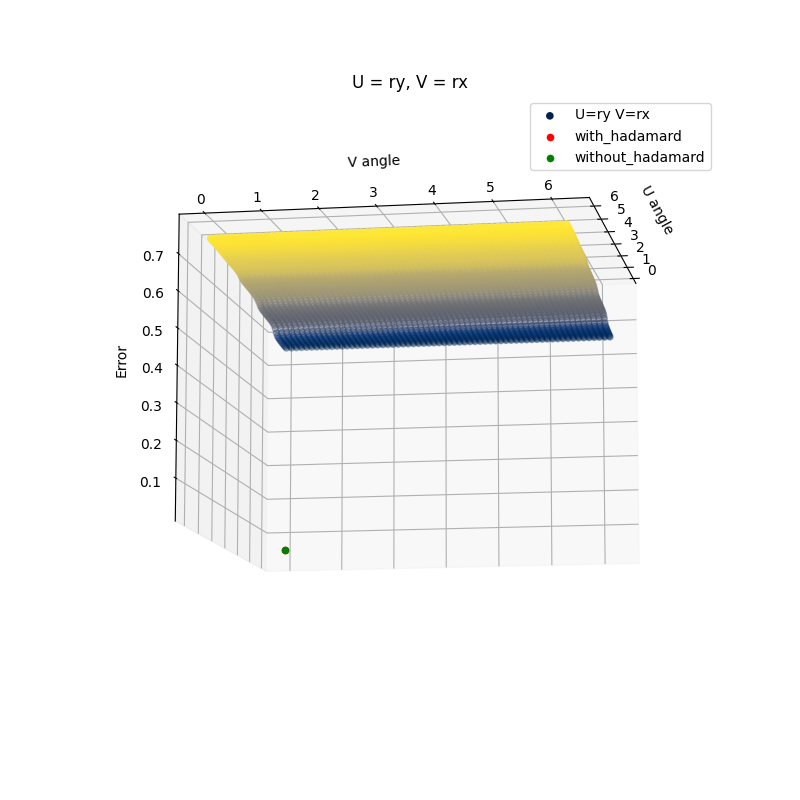

In [28]:
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection='3d')
ax.grid()
ax.set_title('U = ry, V = rx')
ax.set_xlabel('U angle')
ax.set_ylabel('V angle')
ax.set_zlabel('Error')

l1 = ax.scatter(x[2], y[2], z[2], c=z[2], cmap='cividis', label='U=ry V=rx')
l2 = ax.scatter(0,0,cost(counts_with_hadamard)['error'], color='red', label='with_hadamard')
l3 = ax.scatter(0,0,cost(counts_without_hadamard)['error'], color='green', label='without_hadamard')
ax.legend(handles=[l1, l2, l3])
ax.view_init(elev=-10, azim=10)
print(f"Error without applying any gate {cost(counts_without_hadamard)}")
print(f"Error after applying hadamard gate {cost(counts_with_hadamard)}")
print(f"Minimum error we found with U=ry V=rx {error[0]}")
plt.show()

Error without applying any gate {'invalid_states_count': 390, 'deviation': 0, 'error': 0.039}
Error after applying hadamard gate {'invalid_states_count': 390, 'deviation': 0, 'error': 0.039}
Minimum error we found with U=ry V=rx {'invalid_states_count': 330, 'deviation': 0, 'error': 0.033, 'index': 1670}


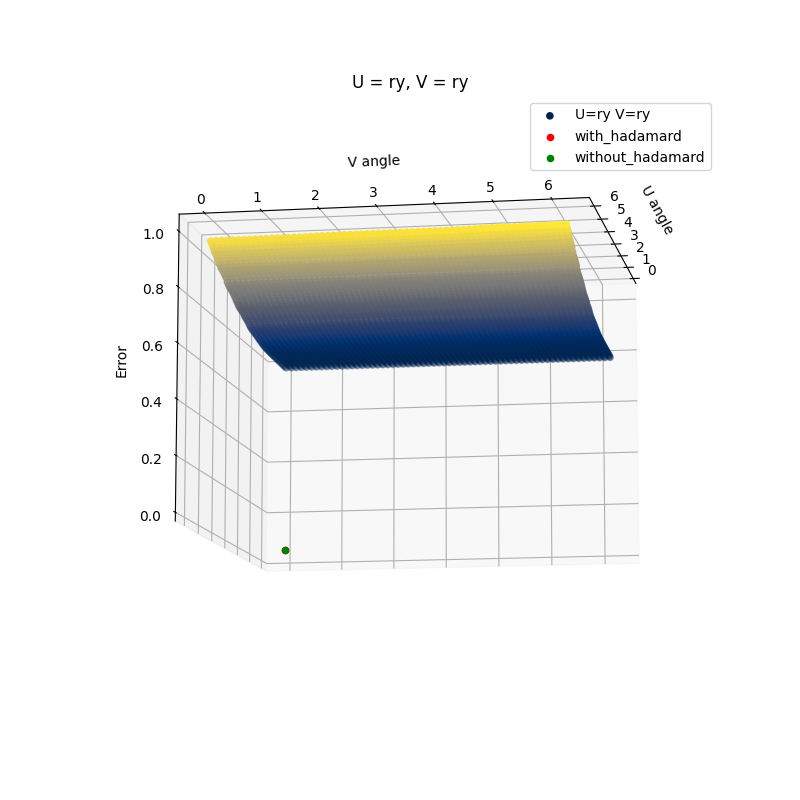

In [29]:
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection='3d')
ax.grid()
ax.set_title('U = ry, V = ry')
ax.set_xlabel('U angle')
ax.set_ylabel('V angle')
ax.set_zlabel('Error')

l1 = ax.scatter(x[3], y[3], z[3], c=z[3], cmap='cividis', label='U=ry V=ry')
l2 = ax.scatter(0,0,cost(counts_with_hadamard)['error'], color='red', label='with_hadamard')
l3 = ax.scatter(0,0,cost(counts_without_hadamard)['error'], color='green', label='without_hadamard')
ax.legend(handles=[l1, l2, l3])
ax.view_init(elev=-10, azim=10)
print(f"Error without applying any gate {cost(counts_without_hadamard)}")
print(f"Error after applying hadamard gate {cost(counts_with_hadamard)}")
print(f"Minimum error we found with U=ry V=rx {error[0]}")
plt.show()

## Now we wish to change the noise model

In [2]:
from depolarization_template import depolarize as dp
min_ckt, min_err_info, min_error = dp(noise_prob=0.08, delay_time=500)

100%|██████████| 16384/16384 [04:39<00:00, 58.56it/s]


In [5]:
print(min_err_info)

{'invalid_states_count': 1405, 'deviation': 0, 'error': 0.1405, 'index': 15691}


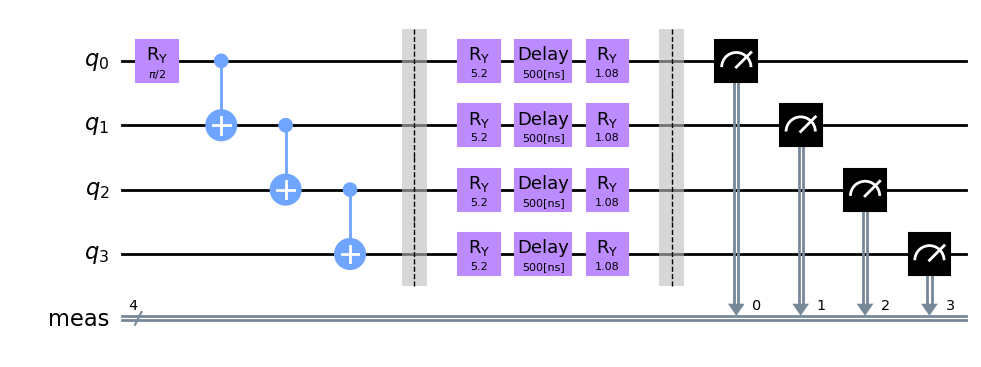

In [6]:
min_ckt.draw('mpl')

## And we run our optimal circuit with different levels of noise and delay

In [48]:
from tqdm import tqdm
ckts_list = []
error_list = []
error_dict_list = []

for delay in tqdm(range(500,1200,100)):
  noise_prob = 0.005
  while(noise_prob<=0.05):
    print(f"@@@@@ noise_prob = {noise_prob} delay = {delay}")
    min_ckt, min_err_info, min_error = dp(noise_prob,delay)
    ckts_list.append(min_ckt)
    error_dict_list.append(min_error_info)
    error_list.append(min_error)
    noise_prob += 0.005

  0%|          | 0/7 [00:00<?, ?it/s]

@@@@@ noise_prob = 0.005 delay = 500


  0%|          | 0/7 [00:32<?, ?it/s]


KeyboardInterrupt: 

Uncomment the lines below to save progress. Be careful the file may be large

In [18]:

# import pickle
# data = {
# 'x':x_list,
# 'y':y_list,
# 'z':z_list,
# 'ckts': ckts_list,
# 'errors':error_list,
# 'opt_idx':opt_idx_list,
# 'mini_err_ckt':min_err_ckt_list
# }

# with open("depolarization.pkl", "wb") as file:
#     pickle.dump(data, file)

Error after Fixing *delay*, changing error probability $p$

In [50]:
list_high = 0.05
incr = 0.005
idx = 0.005
x_axis_p_error = []
while(idx<=list_high):
    x_axis_p_error.append(round(idx, 4))
    idx += incr

list_high = 1200
incr = 100
idx = 500
x_axis_delay = []
while(idx<=list_high):
    x_axis_delay.append(round(idx, 4))
    idx += incr

print(x_axis_delay, x_axis_p_error)

[500, 600, 700, 800, 900, 1000, 1100, 1200] [0.005, 0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04, 0.045, 0.05]


In [ ]:
l_err = []

for i in range(8):
    l = []
    for j in range(10):
        l.append(error_list[i*10 + j])
    l_err.append(l)
print(l_err)

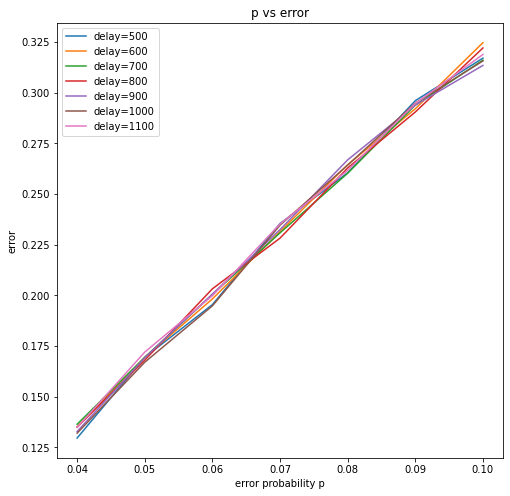

In [150]:
fig, ax = plt.subplots(figsize=(8,8))
l1 = ax.plot(x_axis_p_error, l_err[0])
l2 = ax.plot(x_axis_p_error, l_err[1])
l3 = ax.plot(x_axis_p_error, l_err[2])
l4 = ax.plot(x_axis_p_error, l_err[3])
l5 = ax.plot(x_axis_p_error, l_err[4])
l6 = ax.plot(x_axis_p_error, l_err[5])
l7 = ax.plot(x_axis_p_error, l_err[6])
l8 = ax.plot(x_axis_p_error, l_err[7])
l9 = ax.plot(x_axis_p_error, l_err[8])
l10 = ax.plot(x_axis_p_error, l_err[9])


ax.legend(['delay=500','delay=600','delay=700','delay=800','delay=900','delay=1000','delay=1100', 'delay=1200'])
ax.set_xlabel('error probability p')
ax.set_ylabel('error')
ax.set_title('p vs error')
plt.show()

In [160]:
l_err = []

for i in range(10):
    l = []
    for j in range(8):
        l.append(error_list[j*10 + i])
    l_err.append(l)
print(l_err)

0.1364

Error after fixing error probability *p*, changing delay 

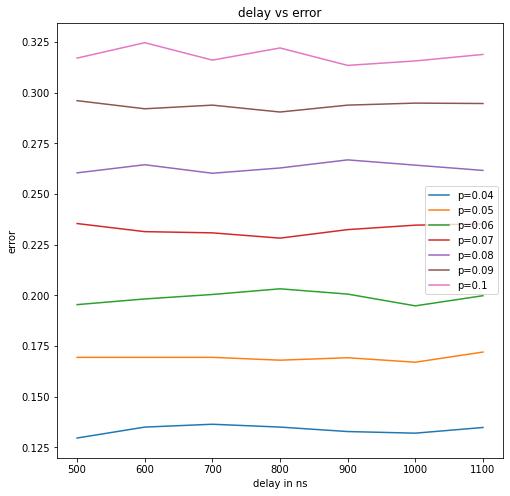

In [162]:
fig, ax = plt.subplots(figsize=(8,8))

l1 = ax.plot(x_axis_delay, l_err[0])
l2 = ax.plot(x_axis_delay, l_err[1])
l3 = ax.plot(x_axis_delay, l_err[2])
l4 = ax.plot(x_axis_delay, l_err[3])
l5 = ax.plot(x_axis_delay, l_err[4])

l6 = ax.plot(x_axis_delay, l_err[5])
l7 = ax.plot(x_axis_delay, l_err[6])
l8 = ax.plot(x_axis_delay, l_err[7])
l9 = ax.plot(x_axis_delay, l_err[8])
l10 = ax.plot(x_axis_delay, l_err[9])


#[0.005, 0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04, 0.045, 0.05]
ax.legend(['p=0.005','p=0.01','p=0.015','p=0.02','p=0.025','p=0.03','p=0.035', 'p=0.04', 'p=0.045', 'p=0.05'])
ax.set_xlabel('delay in ns')
ax.set_ylabel('error')
ax.set_title('delay vs error')
plt.show()

### Plotting some of the minimum error circuits with some particular value of delay and $p$

In [165]:
len(ckts_list) ## For each delay, and each error probability

49

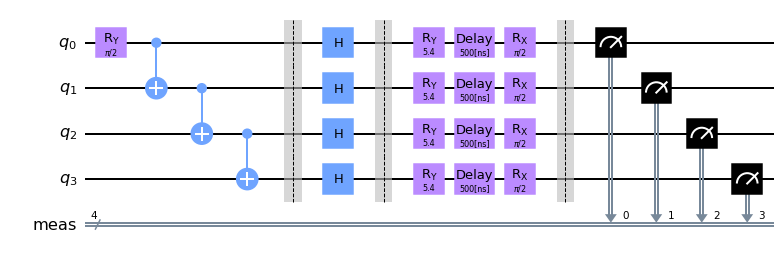

In [170]:
ckts_list[0].draw('mpl')

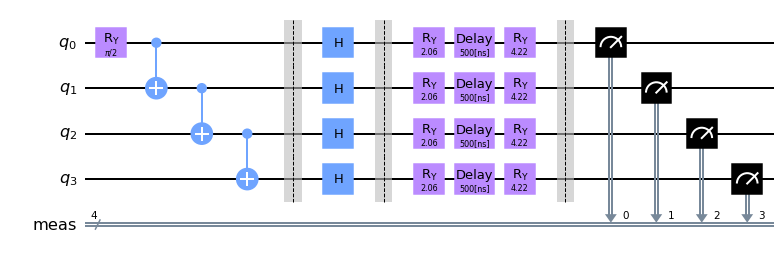

In [171]:
ckts_list[1].draw('mpl')

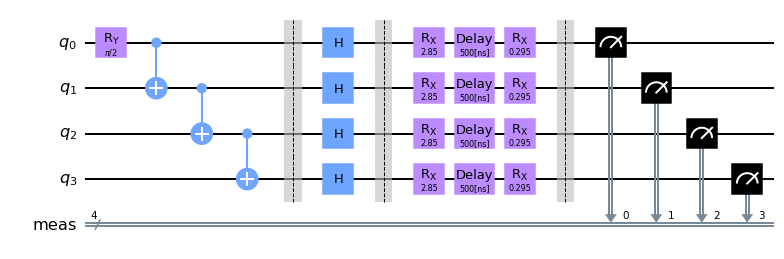

In [172]:
ckts_list[3].draw('mpl')

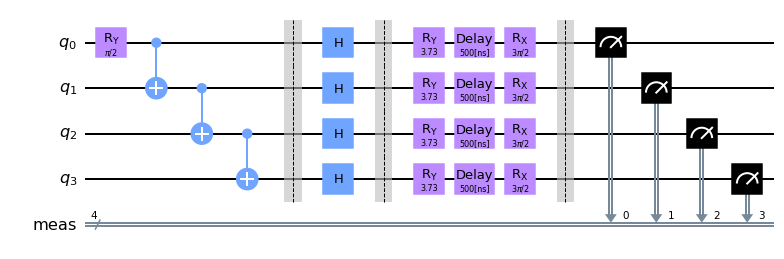

In [173]:
ckts_list[4].draw('mpl')

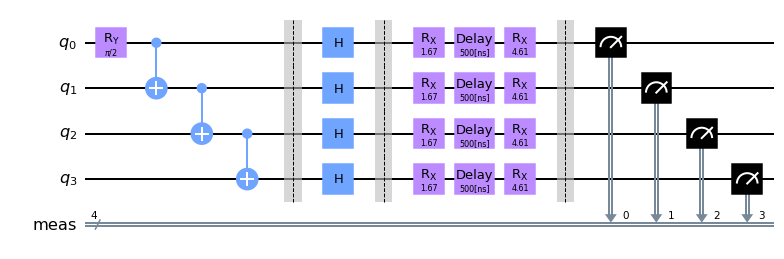

In [174]:
ckts_list[5].draw('mpl')

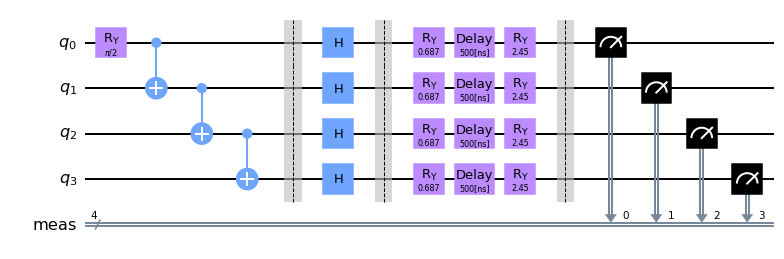

In [175]:
ckts_list[6].draw('mpl')

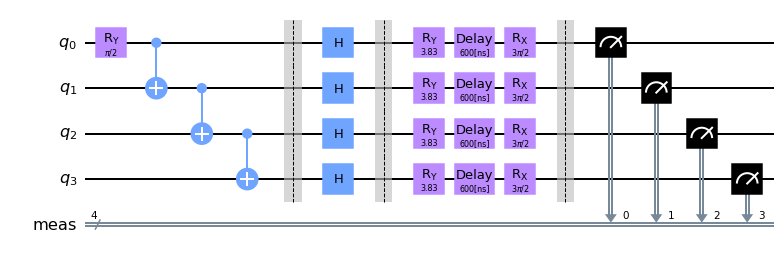

In [176]:
min_err_ckt_list[7].draw('mpl')

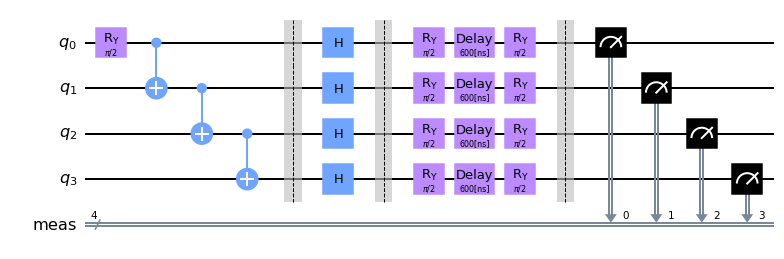

In [177]:
min_err_ckt_list[8].draw('mpl')

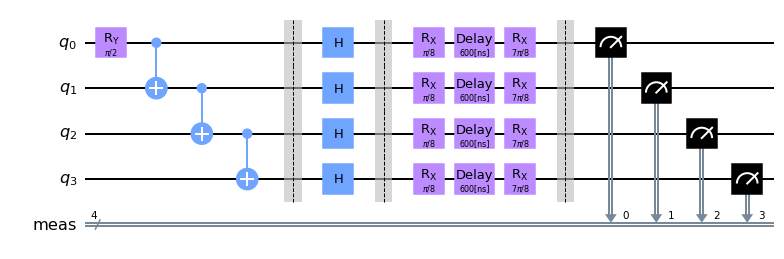

In [178]:
min_err_ckt_list[9].draw('mpl')

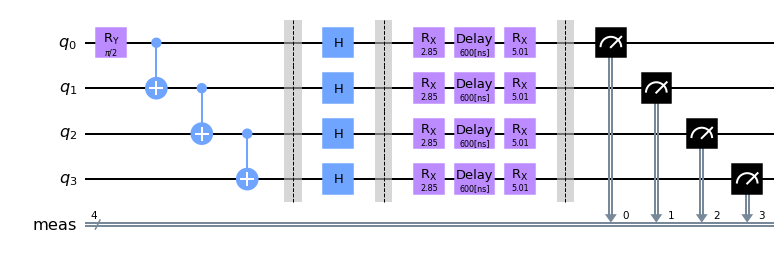

In [179]:
min_err_ckt_list[10].draw('mpl')

In [180]:
%qiskit_version_table